# Regridding sea ice observational data
In this notebook, we will regrid sea ice concentration data from the [NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4](https://nsidc.org/data/g02202/versions/4), available in Gadi, to allow for comparison against earth system model outputs.  
  
We will use the $1^{\circ}$ grid from GFDL-MOM6-COBALT2, which is used as forcing for FishMIP models. This is not the native model grid, instead it was regridded by the ISIMIP team to a regular grid for use by FishMIP. GFDL-MOM6-COBALT2 outputs are available from the DKRZ server and the [ISIMIP data portal](https://data.isimip.org/).

## Loading relevant libraries

In [9]:
#File management
import os
from glob import glob

#Data wrangling
import numpy as np
import xarray as xr

#Projections
from pyproj import Transformer, transform

#Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#Regridding
import xesmf as xe

## Setting working directory

In [2]:
os.chdir('/g/data/jk72/la6889/FishMIP/SOMEME/')

## Loading sea ice concentration (SIC) data from observations
GADI has SIC data for the northern and southern hemisphere at daily and monthly temporal resolutions. For this comparison, we will use monthly data for the southern hemisphere as our focus is the Southern Ocean.

0.3.0


/jobfs/114033743.gadi-pbs/ipykernel_228051/2570983447.py:14: UserWarning: rename 'tdim' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  nsidc_ds = nsidc_ds.rename({'tdim': 'time'})


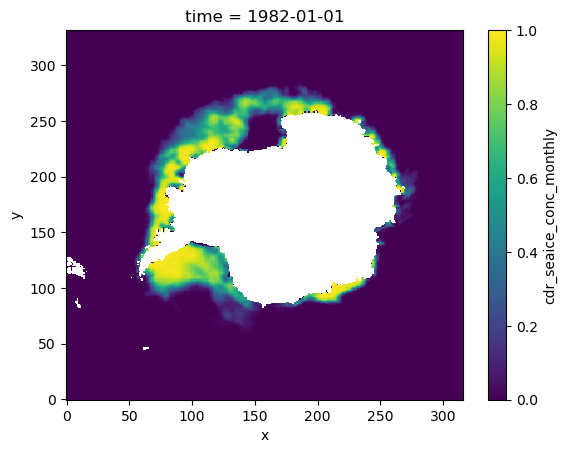

In [3]:
#File containing all SIC data - Adding search term for monthly and Southern Ocean data ("monthly_sh")
base_sic_path = '/g/data/hh5/tmp/cosima/observations/NOAA/G02202_V4/*monthly_sh_197811_202212*.nc'

#Get a list of paths with all available data
[monthly_sic_path] = glob(base_sic_path)
#Loading dataset
nsidc_ds = xr.open_dataset(monthly_sic_path, decode_times = False, autoclose = True)['cdr_seaice_conc_monthly']

#Getting time units to decode time correctly
time_units = nsidc_ds.time.units
#Decode time
decoded_time = xr.conventions.times.decode_cf_datetime(nsidc_ds.time, time_units)
#Rename time dimension
nsidc_ds = nsidc_ds.rename({'tdim': 'time'})
#Add decoded time to dataset
nsidc_ds['time'] = ('time', decoded_time, {'long_name': 'time', 'decoded_using': time_units})

#Subset dataset for period of interest
nsidc_ds = nsidc_ds.sel(time = slice('1982', '2010'))

#Change flag values (any pixels with values anbove 1) to NAs
nsidc_ds = xr.where(nsidc_ds > 1, np.nan, nsidc_ds)

#Checking first time step
nsidc_ds.isel(time = 0).plot()

## Preparing observations for regridding
We will need to rename the coordinates of the observational dataset to meet the requirements of the `xesmf.Regridder` function.

In [4]:
nsidc_ds = nsidc_ds.rename({'xgrid': 'lon', 
                            'ygrid': 'lat'})
nsidc_ds

<xarray.DataArray 'cdr_seaice_conc_monthly' (time: 348, y: 332, x: 316)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2010-12-01
    lon      (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    lat      (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Dimensions without coordinates: y, x

The coordinates for SIC observations are not in degrees, instead they are in meters because the data has a south polar stereographic projection ([EPSG:3976](https://epsg.io/3976)). Before we can regrid the data, we need to use reference system WGS84 ([EPSG:4326](https://epsg.io/4326)), which uses degrees for coordinates.  
  
It is worth noting that after transforming our data, we would not expect it to be plotted in a regular grid. Below, we will plot the first time step of the SIC observations as if it was transformed to WGS84, so we can compare the results of the transformation later.

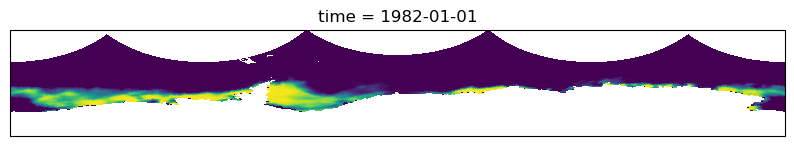

In [10]:
#Initialise plot
fig = plt.figure(figsize = (10, 5))
#Add figure - We will plot the map in WGS84 (i.e., PlateCarree)
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
#Plot first time step - Include original data projection
nsidc_ds.isel(time = 0).plot.pcolormesh(x = 'lon', y = 'lat', 
                                        transform = ccrs.SouthPolarStereo(),
                                        add_colorbar = False)

This is what our data should look like after transformation to WGS84. Npw we are ready to transform our data.

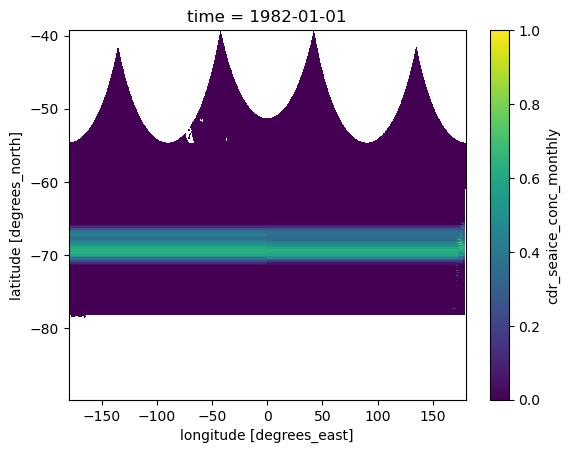

In [11]:
# Convert the 1d coordinates to 2d arrays covering the whole grid
X, Y = np.meshgrid(nsidc_ds.lon, nsidc_ds.lat)
# Use proj to create a transformation from the source coordinates to lat/lon
trans = Transformer.from_crs('epsg:3976', 'epsg:4326')
# Convert the 2d coordinates from the source to the target values
lat, lon = trans.transform(X, Y)
# Add the coordinates to the original dataset
nsidc_ds.coords['lat'] = (('y','x'), lat)
nsidc_ds.coords['lon'] = (('y','x'), lon)
# And add standard metadata so the lat and lon get picked up by xesmf
nsidc_ds.coords['lat'].attrs['units'] = 'degrees_north'
nsidc_ds.coords['lon'].attrs['units'] = 'degrees_east'
nsidc_ds.coords['lat'].attrs['axis'] = 'Y'
nsidc_ds.coords['lon'].attrs['axis'] = 'X'
nsidc_ds.coords['lat'].attrs['standard_name'] = 'latitude'
nsidc_ds.coords['lon'].attrs['standard_name'] = 'longitude'

#Plotting first time step
nsidc_ds.isel(time = 0).plot.pcolormesh(x = 'lon', y = 'lat')

The plot does not look great as it is, but if we use the code to produce the comparison map two chunks above, we can set the map to be in south polar projection.

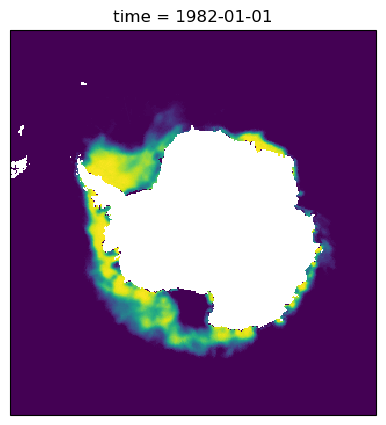

In [12]:
#Initialise plot
fig = plt.figure(figsize = (10, 5))
#Add figure - We will use the south polar projection
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
#Plot first time step - Data is now in WGS84 (i.e., PlateCarree)
nsidc_ds.isel(time = 0).plot.pcolormesh(x = 'lon', y = 'lat', 
                                        transform = ccrs.PlateCarree(),
                                        add_colorbar = False)

Data is plotted correctly, so we can move onto regridding it.

## Regridding SIC observations
We will need to load a sample of our target grid, which in our case is the grid from GFDL-MOM6-COBALT2.

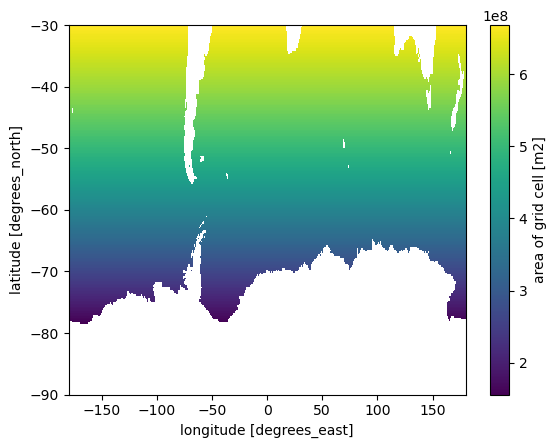

In [13]:
#Load GFDL data
gfdl_grid = xr.open_dataarray('data/gfdl-mom6-cobalt2_areacello_15arcmin_global_fixed.nc')
#Select area of interest
gfdl_grid = gfdl_grid.sel(lat = slice(-30, -90))
#Check result
gfdl_grid.plot()

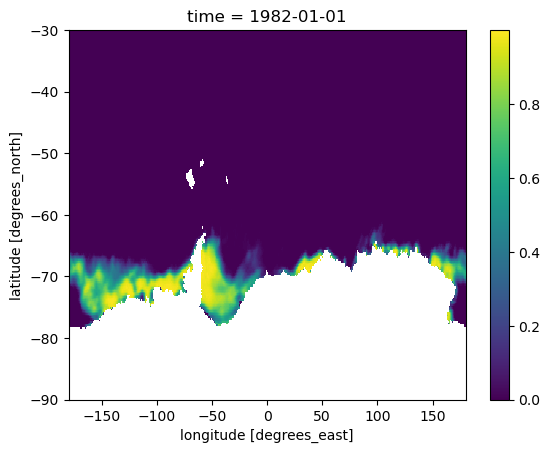

In [14]:
#Calculate regridder
reg = xe.Regridder(nsidc_ds, gfdl_grid, 'bilinear')
#Apply regridder
nsidc_ds_reg = reg(nsidc_ds)

#Check results
nsidc_ds_reg.isel(time = 0).plot()

The data has been successfully regridded. We can store the data for comparisons later.

In [15]:
nsidc_ds_reg.to_netcdf('data/SIC_NASA/sic_nasa_goddard_15arcmin_1982-2010.nc')